In [1]:
using CSV, DataFrames
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")
st = pyimport("scipy.stats")

PyObject <module 'scipy.stats' from 'C:\\Users\\gabipana\\.julia\\conda\\3\\lib\\site-packages\\scipy\\stats\\__init__.py'>

In [24]:
region = "california"

# Select 3 of the best cell sizes from parameter dependency analysis
if region == "romania"
    cell_sizes = [3.5,  4.5,  5.5];
    multiplier = [0.6, 1.0, 1.5]
elseif region == "california"
    cell_sizes = [1.0, 1.5, 2.0];
    multiplier = [0.8, 1.0, 2.2]
elseif region == "italy"
    cell_sizes = [4.0, 4.5, 5.0];
    multiplier = [0.4, 1.0, 2.5]
elseif region == "japan"
    cell_sizes = [2.5, 3.0, 3.5];
    multiplier = [0.3, 1.0, 3.0]
end;
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
# magnitude_threshold = 0.0

# Make path for results
mkpath("./results/$region")

i=3

3

In [25]:
df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
MG = create_network(df, df_cubes)
degrees=[]
for i in 1:nv(MG)
    push!(degrees, get_prop(MG, i, :degree))
end

x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


(Int32[2, 4, 6, 8, 10, 11, 12, 14, 16, 18  …  2566, 2698, 3072, 3138, 3272, 3524, 3712, 4478, 5162, 5530], [1.0, 0.532967032967033, 0.3850078492935636, 0.30854649552128544, 0.2599501338997138, 0.22607119770985318, 0.22605965463108324, 0.2006302521008403, 0.18032597654446392, 0.1644657863145258  …  0.00011543078769971071, 0.00010388770892977295, 9.234463015972416e-5, 8.08015513897864e-5, 6.925847261984863e-5, 5.7715393849799845e-5, 4.617231507986208e-5, 3.4629236309924316e-5, 2.308615753998655e-5, 1.1543078769937765e-5])

In [82]:
# sigma = Vector{Float64}(undef, length(x_ccdf_original_data))
# fill!(sigma, 9000);

In [83]:
fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
# @. tsallis_ccdf(x, α, λ, c) = c*((1+x/λ)^(-α))
# @. tsallis_ccdf(x, α, λ, c) = real(c*(Complex(1+x/(λ))^(-α)))
@. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))
# popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, p0=[2, 7, 0.8], bounds=(0, Inf), maxfev=5000)
popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=3000)


alpha = round(popt_tsallis[1], digits=2)
lambda = round(popt_tsallis[2], digits=2)
c = round(popt_tsallis[3], digits=2)
println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])

alpha= 0.9934100836233852
lambda= 1.2446103956708692
c= 2.7146784909515516


In [75]:
# fit_tsallis_log = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
# @. tsallis_log_ccdf(x, α, λ, c) = c*((1-x/λ)^(-α))
# popt_tsallis_log, pcov_tsallis_log = so.curve_fit(fit_tsallis_log((x, α, λ, c)->log10.(tsallis_log_ccdf(x, α, λ, c))), log10.(x_ccdf_original_data), log10.(y_ccdf_original_data), p0=[2, 7, 0.8], bounds=(0, Inf), maxfev=5000)

# alpha_log = round(popt_tsallis_log[1], digits=2)
# lambda_log = round(popt_tsallis_log[2], digits=2)
# c_log = round(popt_tsallis_log[3], digits=2)
# println("alpha= ", popt_tsallis_log[1],"\nlambda= ", popt_tsallis_log[2], "\nc= ", popt_tsallis_log[3])

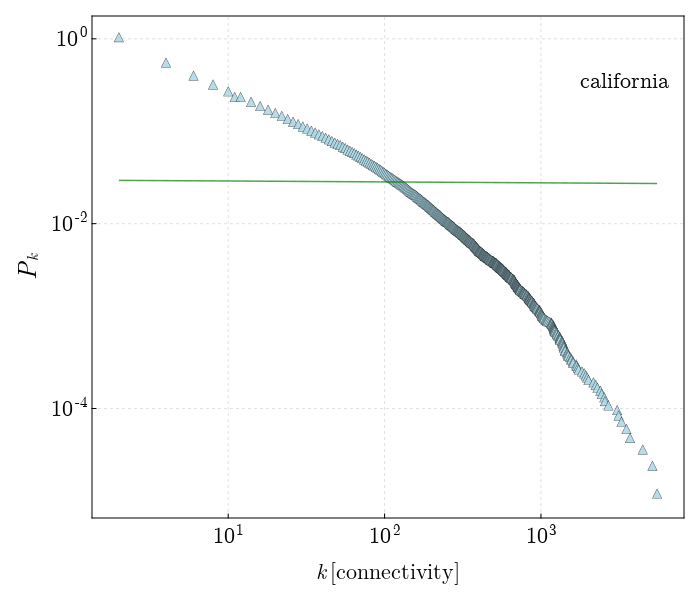

In [88]:
markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", ylabelsize = 26, xscale=log10, yscale=log10,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)


sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)



# lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
#     color=(line_colors[1], 0.7), strokewidth=0.1)

lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, 0.01, 0.3, 0.03), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
    color=(line_colors[2], 0.7), strokewidth=0.1)

# lines!(ax1, x_ccdf_original_data, tsallis_log_ccdf(log10.(x_ccdf_original_data), popt_tsallis_log[1], popt_tsallis_log[2], popt_tsallis_log[3]), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
#     color=(line_colors[2], 0.7), strokewidth=0.1)   

# lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, 2.2, 7.5, 0.8), 
#     color=(line_colors[3], 0.7), strokewidth=0.1)


# lines!(ax1, x_ccdf_original_data, lomax_ccdf(x_ccdf_original_data, k), label= L"k=%$(k)",
#     color=(line_colors[1], 0.7), strokewidth=0.1)

# lines!(ax1, x_ccdf_original_data, zipf_mandelbrot_ccdf(x_ccdf_original_data, gamma, c, z), label= L"\gamma=%$(gamma),\, k=%$(k), \, z=%$(z)",
# color=(line_colors[2], 0.7), strokewidth=0.1)


# # Top right, cell size legend
# axislegend(ax1, [sc1], [L"L=%$(cell_sizes[i])"] ,  position = :rt, bgcolor = (:grey90, 0.25), labelsize=16);
# # Bottom left, results legend
# axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

text!(ax1, region, space = :relative, position = Point2f(0.825, 0.84), fontsize=22)

# save( "./results/$region/tsallis_$(region)_cell_size_$(cell_sizes[i]).png", fig, px_per_unit=5)

fig

In [47]:
fit_lomax = pyeval("""lambda fit: lambda a, b: fit(a, b)""")
@. lomax_ccdf(x, k) = k*(1+x)^(-k-1)
popt_lomax, pcov_lomax = so.curve_fit(fit_lomax((x, k)->lomax_ccdf(x, k)), x_ccdf_original_data, y_ccdf_original_data, p0=[1.5], bounds=(0, Inf), maxfev=5000)

k = round(popt_lomax[1], digits=2)
println("\n\nk= ", k)

1

In [ ]:
res = st.fit(st.lomax, x_ccdf_original_data, bounds=[(0, 500),(0, 500)])
c = res.params[1]

y_lomax_cdf = st.lomax.cdf(x_ccdf_original_data, c)
y_lomax_ccdf = 1 .- y_lomax_cdf

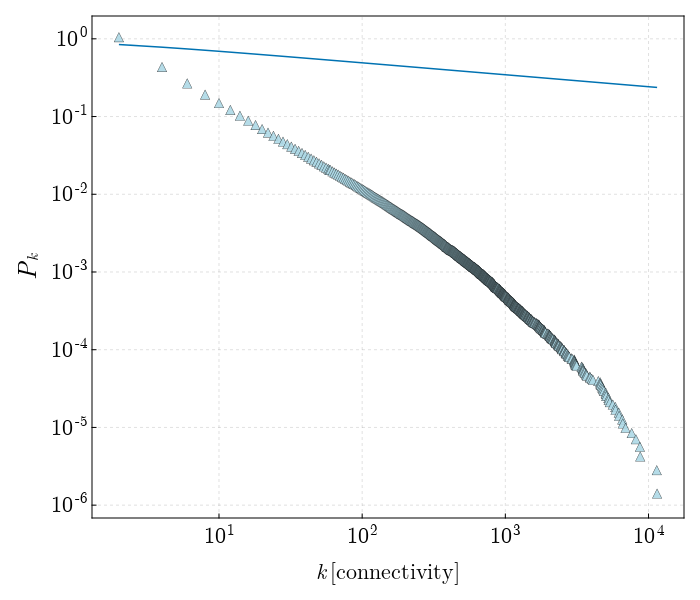

In [181]:
markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", ylabelsize = 26, xscale=log10, yscale=log10,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)


sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

lines!(ax1, x_ccdf_original_data, y_lomax_ccdf)


# lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, alpha, lambda, c), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
#     color=(line_colors[1], 0.7), strokewidth=0.1)

# lines!(ax1, x_ccdf_original_data, lomax_ccdf(x_ccdf_original_data, k), label= L"k=%$(k)",
#     color=(line_colors[1], 0.7), strokewidth=0.1)

# lines!(ax1, x_ccdf_original_data, zipf_mandelbrot_ccdf(x_ccdf_original_data, gamma, c, z), label= L"\gamma=%$(gamma),\, k=%$(k), \, z=%$(z)",
# color=(line_colors[2], 0.7), strokewidth=0.1)


# Top right, cell size legend
# axislegend(ax1, [sc1], [L"L=%$(cell_sizes[1])"] ,  position = :rt, bgcolor = (:grey90, 0.25), labelsize=16);
# # # Bottom left, results legend
# axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

# text!(ax1, "California", space = :relative, position = Point2f(0.825, 0.84), fontsize=22)

# save( "./results/$region/tsallis_$(region)_cell_size_$(cell_size[i]).png", fig, px_per_unit=5)

fig

In [ ]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)

########################################## TRUNCATED
ax2 = Axis(fig, bbox = BBox(150,400,106,320), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

sc1 = Array{Any,1}(undef,3)

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=2)
    xmin = Int(round(fit.xmin, digits=2))
    KS = round(fit.power_law.KS(data=degrees), digits=3)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

    sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
    color=line_colors[i], linewidth=2.5, strokewidth=5) 


    ########################################### TRUNCATED
    # CCDF of truncated data (fitted), the plot, (re-normed)
    scatter!(ax2, multiplier[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data (re-normed)
    lines!(ax2, multiplier[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

end


text!(ax2, "only fitted data\nCCDFs", space = :relative, position = Point2f(0.03, 0.03))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


# Top right, cell size legend
axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], position = :rt, bgcolor = (:grey90, 0.25), labelsize=16);
# Bottom left, results legend
axislegend(ax1, position = :rb, bgcolor = (:grey90, 0.25), labelsize=16);



if region == "romania"
    text!(ax1, "Romania", space = :relative, position = Point2f(0.84, 0.75), fontsize=22)
    ylims!(ax1, 10^(-5.5), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3)],["1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(2), 10^(3)], [L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.7), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.13, 0.5), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)
elseif region == "california"
    text!(ax1, "California", space = :relative, position = Point2f(0.825, 0.75), fontsize=22)
    ylims!(ax1, 10^(-7), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(2), 10^(3),10^(4)], [L"10^{2}", L"10^{3}", L"10^{4}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.63, 0.75), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.15, 0.5), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)
elseif region == "italy"
    text!(ax1, "Italy", space = :relative, position = Point2f(0.87, 0.75), fontsize=22)
    ylims!(ax1, 10^(-6), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.52, 0.75), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.12, 0.65), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)
elseif region == "japan"
    text!(ax1, "Japan", space = :relative, position = Point2f(0.865, 0.75), fontsize=22)
    ylims!(ax1, 10^(-7.5), 1.5)
    ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.5, 0.8), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.65), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)
end




# Save plot
save( "./results/$region/$(region)_best_fits_all_data.png", fig, px_per_unit=7)
save( "./results/$region/$(region)_best_fits_all_data.pdf", fig)
fig
